In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import read_data as rd  # Importing the read_data.py module
from sklearn.svm import SVC
from scipy.fft import fft

In [2]:
# Load data
dataset_dir = '/home/ecappiell/datasets/full'
data_arrays, labels, class_ids = rd.process_mafaulda_data(dataset_dir)

In [3]:
# Original sampling rate (in Hz)
original_sampling_rate = 50 * 10**3  # 50 kHz

# Target sampling rate (in Hz)
target_sampling_rate = 1 * 10**3  # 10 kHz

# Downsample the data
downsampled_data = rd.downsample_data(data_arrays, original_sampling_rate, target_sampling_rate)

In [4]:
# Function to normalize the data using min-max scaling
def normalize_data(data):
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    normalized = (data - min_val) / (max_val - min_val)
    return normalized

In [5]:
def extract_fft_features(signal, fs, max_frequency=500):
    N = len(signal)
    T = 1.0 / fs
    yf = fft(signal)
    xf = np.fft.fftfreq(N, T)[:N//2]
    yf = 2.0/N * np.abs(yf[:N//2])
    
    # Find the index corresponding to the maximum frequency
    max_index = int(max_frequency * N / fs)
    
    fft_features = yf[:max_index]
    return fft_features

In [6]:
# Normalize the downsampled data
normalized_data = np.array([normalize_data(signal) for signal in downsampled_data])

In [7]:
# Extract FFT features for each signal up to 500 Hz
X = []
for signal in normalized_data:
    fft_features = np.array([extract_fft_features(signal[:, i], target_sampling_rate*5) for i in range(8)])
    X.append(fft_features)
X = np.array(X)

In [8]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, class_ids, test_size=0.2, random_state=37)

In [9]:
# Reshape X_train and X_test to 2D
X_train_flatten = X_train.reshape(X_train.shape[0], -1)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)

In [10]:
# Initialize SVC
svc = SVC()

In [11]:
# Train the model
svc.fit(X_train_flatten, y_train)

SVC()

In [12]:
# Predictions on the test set
y_pred_svc = svc.predict(X_test_flatten)

In [13]:
# Evaluate the model
accuracy_svc = accuracy_score(y_test, y_pred_svc)
precision_svc = precision_score(y_test, y_pred_svc, average='weighted')
recall_svc = recall_score(y_test, y_pred_svc, average='weighted')
f1_svc = f1_score(y_test, y_pred_svc, average='weighted')
conf_matrix_svc = confusion_matrix(y_test, y_pred_svc)

print("SVC Accuracy:", accuracy_svc)
print("SVC Precision:", precision_svc)
print("SVC Recall:", recall_svc)
print("SVC F1 Score:", f1_svc)

SVC Accuracy: 0.6240409207161125
SVC Precision: 0.6271585394112543
SVC Recall: 0.6240409207161125
SVC F1 Score: 0.6083072506746213


/home/ecappiell/dev/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


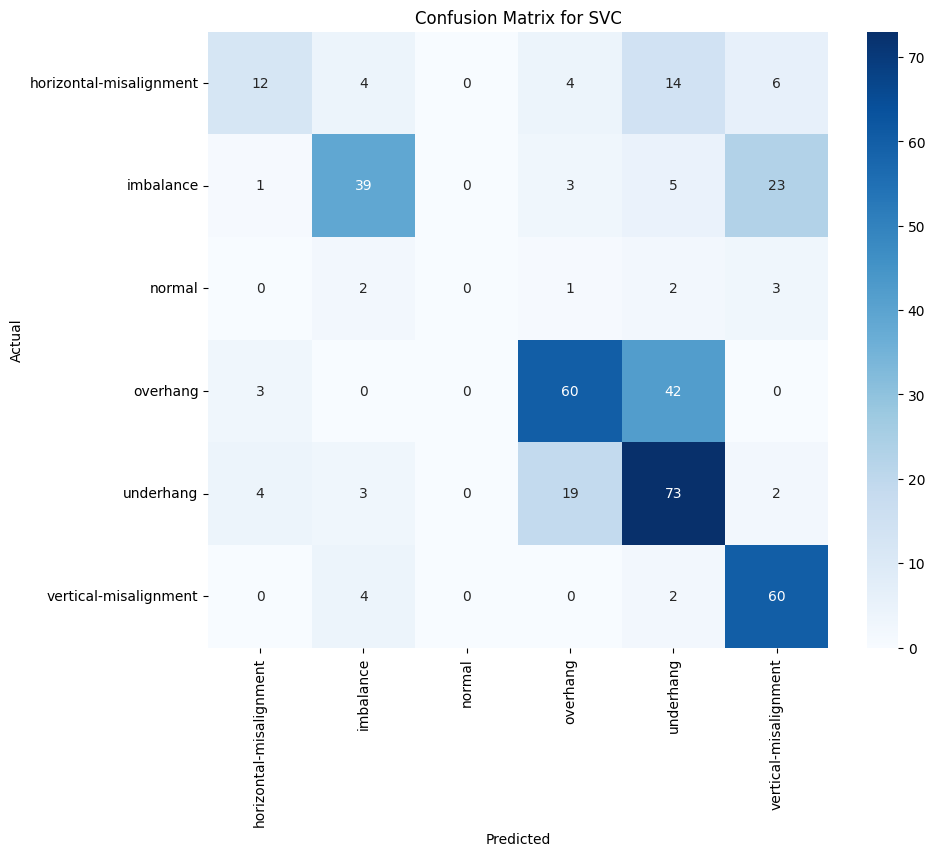

In [14]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_svc, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for SVC')
plt.show()